# Load data functions

In [1]:
# Los datos .csv contienen a todos los robots por ende es necesario filtrarlo
def robot_filter(robot_id, team, df):
    robot_data = df[(df['RobotID'] == robot_id) & (df['Team'] == team)]
    robot_data = robot_data[["ElapsedTime", "Pos_X","Pos_Y","Orientation", "Vx_Command","Vy_Command","Vx_Actual","Vy_Actual","Angular_Command"]]
    robot_data = robot_data.rename(columns={'Pos_X': 'x',
                                            'Pos_Y':'y',
                                            'Orientation':'theta',
                                            'Vx_Actual':'vx',
                                            'Vy_Actual':'vy',
                                            'Angular_Command':'omega_cmd',
                                            "Vx_Command":"vx_cmd",
                                            "Vy_Command":"vy_cmd"})
    return robot_data

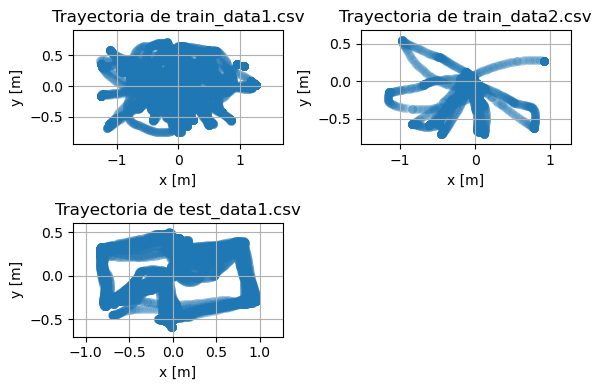

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_named_trajectories(filenames, rows, cols, robot_id=0, team=0):
    fig, axes = plt.subplots(rows, cols, figsize=(6, 4))
    axes = axes.flatten()

    for ax, fname in zip(axes, filenames):
        df = pd.read_csv(fname)
        df = robot_filter(robot_id, team, df)

        ax.scatter(df['x'], df['y'], marker='o', linewidth=0.2, alpha = 0.2)
        ax.set_title(f"Trayectoria de {fname}")
        ax.set_xlabel("x [m]")
        ax.set_ylabel("y [m]")
        ax.axis('equal')
        ax.grid(True)

    # Oculta subplots vacíos si hay más espacios que archivos
    for j in range(len(filenames), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_named_trajectories(
    filenames=["train_data1.csv", "train_data2.csv", "test_data1.csv"],
    rows=2,
    cols=2
)

In [3]:
import numpy as np

class ExtendedKalmanFilter:
    def __init__(self, initial_state, initial_covariance, process_noise, measurement_noise):
        """
        Initializes the EKF with initial state and covariance.
        State: [x, y, sin(θ), cos(θ), vx, vy, ω]
        """
        self.x = initial_state
        self.P = initial_covariance
        self.Q = process_noise
        self.R = measurement_noise

    def f(self, x, dt):
        """
        Motion model with orientation represented by sin(θ), cos(θ).
        """
        sin_theta, cos_theta, vx, vy, omega = x[2], x[3], x[4], x[5], x[6]
        theta = np.arctan2(sin_theta, cos_theta)
        theta += omega * dt  # update orientation

        new_x = x.copy()
        new_x[0] += vx * dt
        new_x[1] += vy * dt
        new_x[2] = np.sin(theta)
        new_x[3] = np.cos(theta)
        # vx, vy, omega unchanged
        return new_x

    def h(self, x):
        """
        Measurement model: returns [x, y, θ] from [x, y, sin(θ), cos(θ), ...]
        """
        theta = np.arctan2(x[2], x[3])
        return np.array([x[0], x[1], theta])

    def jacobian_f(self, x, dt):
        """
        Jacobian of motion model f w.r.t. state x.
        Approximate linearized model.
        """
        F = np.eye(7)
        F[0, 4] = dt  # ∂x/∂vx
        F[1, 5] = dt  # ∂y/∂vy

        theta = np.arctan2(x[2], x[3])
        omega = x[6]
        theta_new = theta + omega * dt
        F[2, 6] = dt * np.cos(theta_new)  # ∂sin(θ)/∂ω
        F[3, 6] = -dt * np.sin(theta_new)  # ∂cos(θ)/∂ω

        return F

    def jacobian_h(self, x):
        """
        Jacobian of measurement model h w.r.t. state x.
        """
        H = np.zeros((3, 7))
        H[0, 0] = 1  # ∂x_meas/∂x
        H[1, 1] = 1  # ∂y_meas/∂y

        sin_theta = x[2]
        cos_theta = x[3]
        denom = sin_theta**2 + cos_theta**2
        H[2, 2] = cos_theta / denom  # ∂θ/∂sin(θ)
        H[2, 3] = -sin_theta / denom  # ∂θ/∂cos(θ)

        return H

    def predict(self, dt):
        """
        EKF prediction step.
        """
        F = self.jacobian_f(self.x, dt)
        self.x = self.f(self.x, dt)
        self.P = F @ self.P @ F.T + self.Q

    def update(self, z):
        """
        EKF update step with measurement z.
        """
        H = self.jacobian_h(self.x)
        y = z - self.h(self.x)
        y[2] = (y[2] + np.pi) % (2 * np.pi) - np.pi  # wrap θ error

        S = H @ self.P @ H.T + self.R
        K = self.P @ H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(len(self.x)) - K @ H) @ self.P

    def get_state(self):
        return self.x

    def get_covariance(self):
        return self.P

In [4]:
import numpy as np

def compute_velocity(position_series, dt=1/60):
    """
    Computes velocity using explicit finite differences from a position time series.

    Parameters:
        position_series (array-like): Smoothed position values (e.g., x or y)
        dt (float): Time step between samples (default 1/60 for 60Hz)

    Returns:
        velocity_series (np.ndarray): Estimated velocity
    """
    position_array = np.asarray(position_series)
    N = len(position_array)
    velocity = np.zeros(N)

    for i in range(N):
        if i == 0:
            # Forward difference for the first point
            velocity[i] = (position_array[i + 1] - position_array[i]) / dt
        elif i == N - 1:
            # Backward difference for the last point
            velocity[i] = (position_array[i] - position_array[i - 1]) / dt
        else:
            # Central difference for interior points
            velocity[i] = (position_array[i + 1] - position_array[i - 1]) / (2 * dt)

    return velocity


def compute_angular_velocity(orientation_series, dt=1/60):
    """
    Computes angular velocity using finite difference from an angle time series.
    Handles wraparound automatically via np.unwrap.

    Parameters:
        orientation_series (array-like): Smoothed angles (in radians)
        dt (float): Time step between samples (default 1/60 for 60Hz)

    Returns:
        angular_velocity_series (np.ndarray): Estimated angular velocity in rad/s
    """
    theta = np.unwrap(orientation_series)
    omega = np.gradient(theta, dt)
    return omega

In [5]:
import numpy as np
import pandas as pd

def initialize_ekf(df):
    """Inicializa el estado, la covarianza y el EKF"""
    pos_x = df['x'].values
    pos_y = df['y'].values
    orientations = df['theta'].values  # en radianes

    initial_state = np.array([
        pos_x[0],
        pos_y[0],
        np.sin(orientations[0]),
        np.cos(orientations[0]),
        0.0,  # vx
        0.0,  # vy
        0.0   # omega
    ])

    initial_cov = np.diag([1e-7] * 4 + [1.0, 1.0, 1.0])
    process_noise = np.diag([1e-7, 1e-7, 1e-4, 1e-4, 1e-4, 1e-4, 1e-2])
    measurement_noise = np.diag([1e-6, 1e-6, 1e-6])

    ekf = ExtendedKalmanFilter(initial_state, initial_cov, process_noise, measurement_noise)
    return ekf

def run_ekf_filter(df, ekf, dt=0.016):
    """Ejecuta el filtro de Kalman y retorna el DataFrame con las estimaciones"""
    pos_x = df['x'].values
    pos_y = df['y'].values
    orientations = df['theta'].values

    est_tetha, est_vx, est_vy, est_omega = [], [], [], []
    est_x, est_y = [], []

    for i in range(len(df)):
        ekf.predict(dt)
        z = np.array([pos_x[i], pos_y[i], orientations[i]])
        ekf.update(z)

        state = ekf.get_state()
        est_tetha.append(np.arctan2(state[2], state[3]))
        est_vx.append(state[4])
        est_vy.append(state[5])
        est_omega.append(state[6])
        est_x.append(state[0])
        est_y.append(state[1])

    # Guardar en el DataFrame
    df_out = df.copy()
    df_out['filtered_theta'] = est_tetha
    df_out['vx'] = est_vx
    df_out['vy'] = est_vy
    df_out['omega'] = est_omega
    df_out['filtered_x'] = est_x
    df_out['filtered_y'] = est_y

    return df_out

def ekf_filter(df, dt=0.016):
    ekf = initialize_ekf(df)
    return run_ekf_filter(df, ekf, dt)

In [6]:
def transform_global_to_local(df):
    df = df.copy()

    cos_theta = np.cos(df['filtered_theta'].values)
    sin_theta = np.sin(df['filtered_theta'].values)

    vx = df['vx'].values
    vy = df['vy'].values

    # Rotation: global → local
    df['vx'] = cos_theta * vx + sin_theta * vy
    df['vy'] = -sin_theta * vx + cos_theta * vy

    return df

In [7]:
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    df = robot_filter(0, 0, df).reset_index(drop=True)
    df = ekf_filter(df)
    df = transform_global_to_local(df)

    velocity_cols = ['vx', 'vy', 'omega', 'vx_cmd', 'vy_cmd', 'omega_cmd']
    df = df[velocity_cols].copy()

    # Eliminar valores infinitesimales en columnas numéricas
    num_cols = df.select_dtypes(include=['float', 'int']).columns
    epsilon=1e-5
    df[num_cols] = df[num_cols].apply(lambda col: col.where(abs(col) >= epsilon, 0.0))
    return df

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_velocities(df, title_prefix=""):
    """
    Plots predicted and commanded local velocities (vx, vy) over time.

    Args:
        df: DataFrame with columns:
            - 'vx', 'vy': predicted local velocities
            - 'vx_cmd', 'vy_cmd': commanded velocities
        title_prefix: optional prefix for subplot titles
    """
    components = ['vx', 'vy','omega']

    fig, axs = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
    steps = np.arange(len(df))*0.016

    for i, comp in enumerate(components):
        vel = df[comp].values
        cmd = df[f'{comp}_cmd'].values

        axs[i].plot(steps, vel, label=f'{comp} (predicted)', linewidth=2)
        axs[i].plot(steps, cmd, label=f'{comp}_cmd (command)', linestyle='--')
        axs[i].set_ylabel(f'{comp} velocity')
        axs[i].set_title(f"{title_prefix}{comp.upper()} (Local)")
        axs[i].legend()
        axs[i].grid(True)

    axs[-1].set_xlabel("Time")
    plt.tight_layout()
    plt.show()

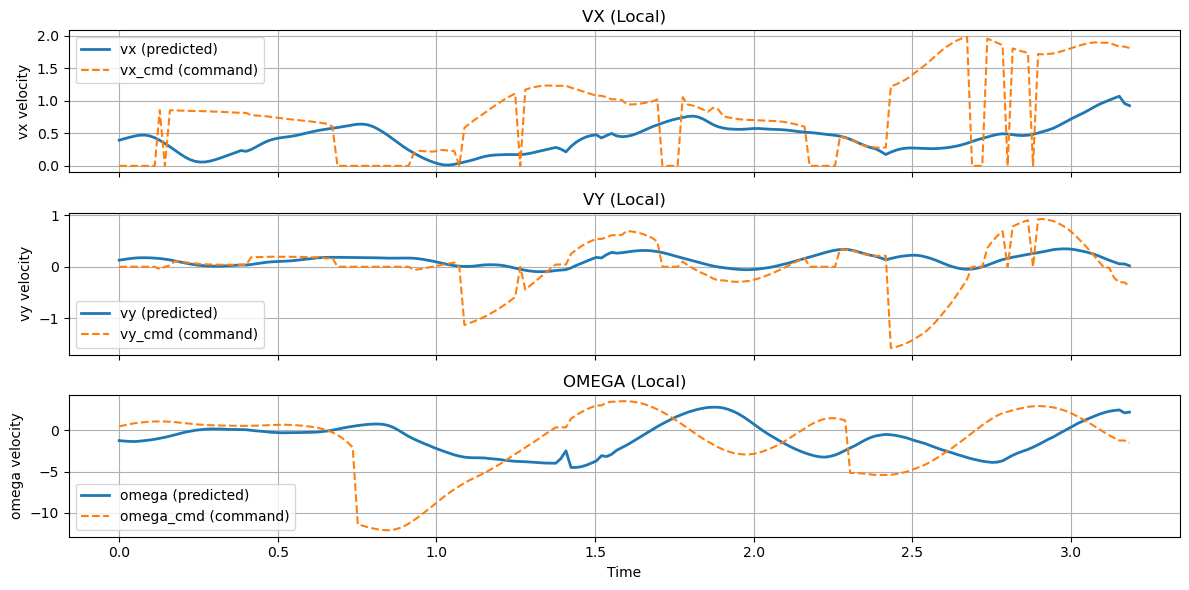

In [ ]:
df = load_and_preprocess_data("test_data1.csv")[200:398]
plot_velocities(df)

Se observan las velocidades comandadas y las velocidades reales que tienen cierto desfase, esto se puede explicar debido a las dinamicas del robot, ya que no puede alcanzar una velocidad instantaneamente sino que el robot tiene que acelerar para alcanzarla.

In [10]:
df.head()

,vx,vy,omega,vx_cmd,vy_cmd,omega_cmd
200,0.395440,0.129150,-1.230739,0.0,0.0,0.503619
201,0.417756,0.143514,-1.290941,0.0,0.0,0.638019
202,0.438802,0.157800,-1.329862,0.0,0.0,0.760563
203,0.457617,0.169041,-1.342808,0.0,0.0,0.873308
204,0.471211,0.175147,-1.303564,0.0,0.0,0.954286


# Training

## Scripts de entrenamiento

In [87]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import joblib

class KinematicsScaler:
    """
    Uses sklearn's MinMaxScaler.
    Columns expected (in this order by default):
    ['vx','vy','omega','vx_cmd','vy_cmd','omega_cmd']
    """
    def __init__(self, *, feature_range=(-1.0, 1.0), columns=None, clip=True):
        self.columns = columns or ['vx','vy','omega','vx_cmd','vy_cmd','omega_cmd']
        self.scaler = MinMaxScaler(feature_range=feature_range, clip=clip)
        self._fitted = False

    # -------- Fit / Save / Load --------
    def fit(self, df: pd.DataFrame):
        missing = [c for c in self.columns if c not in df.columns]
        if missing:
            raise ValueError(f"Missing required columns in DataFrame: {missing}")
        X = df[self.columns].astype(float).values
        self.scaler.fit(X)
        self._fitted = True
        return self

    def save(self, path: str):
        self._check_fitted()
        joblib.dump({'scaler': self.scaler, 'columns': self.columns}, path)

    def load(self, path: str):
        bundle = joblib.load(path)
        self.scaler = bundle['scaler']
        self.columns = list(bundle['columns'])
        self._fitted = True
        return self

    # -------- Accessors (MinMax-specific) --------
    @property
    def data_min_(self):
        self._check_fitted()
        return self.scaler.data_min_

    @property
    def data_max_(self):
        self._check_fitted()
        return self.scaler.data_max_

    @property
    def data_range_(self):
        self._check_fitted()
        return self.scaler.data_range_

    @property
    def mm_scale_(self):
        """scale factor used by MinMax: y = x * mm_scale_ + mm_offset_"""
        self._check_fitted()
        return self.scaler.scale_

    @property
    def mm_offset_(self):
        """offset used by MinMax: y = x * mm_scale_ + mm_offset_"""
        self._check_fitted()
        return self.scaler.min_

    # -------- Transform --------
    def transform(self, x):
        """
        Min-max scale to the configured feature_range.
        Accepts: pandas DataFrame/Series, numpy array, or torch.Tensor.
        For arrays/tensors: last dim must match len(self.columns).
        """
        self._check_fitted()

        if isinstance(x, pd.DataFrame):
            out = x.copy()
            out[self.columns] = self.scaler.transform(out[self.columns].astype(float).values)
            return out

        if isinstance(x, pd.Series):
            arr = x[self.columns].astype(float).values[None, :]
            scaled = self.scaler.transform(arr)[0]
            s = x.copy()
            for i, c in enumerate(self.columns):
                s[c] = scaled[i]
            return s

        if isinstance(x, torch.Tensor):
            scale = torch.tensor(self.mm_scale_,  dtype=x.dtype, device=x.device)
            offset = torch.tensor(self.mm_offset_, dtype=x.dtype, device=x.device)
            return x * scale + offset  # works for (..., 6)

        arr = np.asarray(x, dtype=float)
        return arr * self.mm_scale_ + self.mm_offset_

    # -------- Inverse (vx, vy, omega only by default) --------
    def inverse(self, y, cols=('vx','vy','omega')):
        """
        Inverse-transform only the specified columns.
        Accepts DF/Series/ndarray/torch for the last dim == len(cols).
        """
        self._check_fitted()
        idx = [self.columns.index(c) for c in cols]
        scale  = self.mm_scale_[idx]
        offset = self.mm_offset_[idx]
        dmin   = self.data_min_[idx]  # used if scale==0 (constant feature)

        if isinstance(y, pd.DataFrame):
            out = y.copy()
            Y = out[list(cols)].astype(float).values
            inv = np.empty_like(Y, dtype=float)
            # handle possible zero scale (constant feature)
            nz = scale != 0
            inv[:, nz]  = (Y[:, nz] - offset[nz]) / scale[nz]
            inv[:, ~nz] = dmin[~nz]
            out[list(cols)] = inv
            return out

        if isinstance(y, pd.Series):
            s = y.copy()
            for j, c in enumerate(cols):
                if scale[j] != 0:
                    s[c] = (float(s[c]) - offset[j]) / scale[j]
                else:
                    s[c] = dmin[j]
            return s

        if isinstance(y, torch.Tensor):
            scale_t  = torch.tensor(scale,  dtype=y.dtype, device=y.device)
            offset_t = torch.tensor(offset, dtype=y.dtype, device=y.device)
            dmin_t   = torch.tensor(dmin,   dtype=y.dtype, device=y.device)
            # vectorized safe inverse: where(scale>0, (y-offset)/scale, dmin)
            return torch.where(
                scale_t > 0,
                (y - offset_t) / scale_t,
                dmin_t
            )

        Y = np.asarray(y, dtype=float)
        inv = np.empty_like(Y, dtype=float)
        nz = scale != 0
        inv[..., nz]  = (Y[..., nz] - offset[nz]) / scale[nz]
        inv[..., ~nz] = dmin[~nz]
        return inv

    # -------- Utils --------
    def _check_fitted(self):
        if not self._fitted:
            raise ValueError("Scaler is not fitted/loaded. Call .fit(df) or .load(path) first.")


In [112]:
import torch
from torch.utils.data import Dataset

class RobotDataset(Dataset):
    def __init__(self, filename, horizon_steps=1, scaler : KinematicsScaler = None):
        self.horizon = horizon_steps
        self.df = load_and_preprocess_data(filename)
        if scaler != None:
            # Fit and save
            print("scaling")
            self.df = scaler.transform(self.df)

        # Pre-convertir a tensores una sola vez
        self.state_data = torch.tensor(self.df[['vx', 'vy', 'omega']].values.astype('float32') )
        self.cmd_data = torch.tensor(
            self.df[['vx_cmd', 'vy_cmd', 'omega_cmd']].values.astype('float32'))

        self.valid_len = len(self.df) - self.horizon

    def __len__(self):
        return self.valid_len

    def __getitem__(self, idx):
        # Acceso directo a slices de memoria (sin pandas)
        states = self.state_data[idx : idx + self.horizon]      # [H, 3]
        commands = self.cmd_data[idx : idx + self.horizon]      # [H, 3]
        targets = self.state_data[idx + 1 : idx + 1 + self.horizon]  # [H, 3]

        return {
            'states': states.clone(),    # clone() evita problemas de memoria compartida
            'commands': commands.clone(),
            'targets': targets.clone()
        }

In [93]:
import torch

class Trainer:
    def __init__(self, model, training_loader, loss_fn, optimizer, device, validation_loader=None):
        """
        Args:
            model (nn.Module)
            training_loader (DataLoader)
            loss_fn (callable)
            optimizer (torch.optim.Optimizer)
            device (torch.device or str)
            validation_loader (DataLoader, optional)
        """
        self.model = model
        self.training_loader = training_loader
        self.validation_loader = validation_loader
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = device

    def train_one_epoch(self):
        self.model.train()
        total_loss = 0.0
        num_batches = 0

        for batch in self.training_loader:
            states = batch['states'].to(self.device)
            commands = batch['commands'].to(self.device)
            targets = batch['targets'].to(self.device)
            B, H, _ = states.shape

            pred_state = states[:, 0]
            loss_accum = 0.0

            self.optimizer.zero_grad()

            for t in range(H):
                pred_state = self.model(torch.cat([pred_state, commands[:, t]], dim=1))
                loss_accum += self.loss_fn(pred_state, targets[:, t])

            loss_accum.backward()
            self.optimizer.step()

            total_loss += loss_accum.item()
            num_batches += 1

        return total_loss / max(num_batches, 1)

    def evaluate(self):
        self.model.eval()
        total_mse = 0.0  # MSE acumulativo total
        num_samples = 0   # Total de pasos temporales evaluados

        with torch.no_grad():
            for batch in self.validation_loader:
                states = batch['states'].to(self.device)
                commands = batch['commands'].to(self.device)
                targets = batch['targets'].to(self.device)
                B, H, _ = states.shape

                pred_state = states[:, 0]
                batch_mse = 0.0

                for t in range(H):
                    pred_state = self.model(torch.cat([pred_state, commands[:, t]], dim=1))
                    batch_mse += torch.sum((pred_state - targets[:, t])**2).item()  # Suma cuadrática

                total_mse += batch_mse  # Acumulativo
                num_samples += B * H

        return total_mse / num_samples

    def fit(self, epochs, save_path="best_model.pth"):
        history = []
        has_val = self.validation_loader is not None
        best_val_loss = float("inf")

        for epoch in range(0, epochs):
            train_loss = self.train_one_epoch()

            if has_val:
                val_loss = self.evaluate()
                print(f"Epoch {epoch}/{epochs} - train: {train_loss:.4f} - val: {val_loss:.4f}")
                history.append({'train': train_loss, 'val': val_loss})

                # Guardar si mejora
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(self.model.state_dict(), save_path)
                    print(f"Mejor modelo guardado (val_loss = {val_loss:.4f})")
            else:
                print(f"Epoch {epoch}/{epochs} - train: {train_loss:.4f}")
                history.append({'train': train_loss})

        return history

In [94]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [126]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def run_autoregressive_simulation(model, df):
    """
    Simula en lazo cerrado usando el modelo, autoregresivamente.
    Args:
        model: modelo físico o residual
        df: DataFrame con columnas ['vx', 'vy', 'omega', 'vx_cmd', 'vy_cmd', 'omega_cmd']
    Returns:
        predictions: np.array de shape [T-1, 3]
    """
    model.eval()
    data = torch.tensor(df.values, dtype=torch.float32)
    predictions = []

    # Estado inicial: [vx, vy, omega, vx_cmd, vy_cmd, omega_cmd]
    pos = [0,0]
    state = data[0].clone()

    for t in range(len(data) - 1):
        input_tensor = state.unsqueeze(0)  # [1, 6]
        with torch.no_grad():
            output = model(input_tensor).squeeze(0)  # [3] → [vx, vy, omega]

        # Obtener comando siguiente
        next_cmds = data[t + 1, 3:6]  # [vx_cmd, vy_cmd, omega_cmd]

        # Actualizar estado: nueva predicción + nuevos comandos
        state = torch.cat([output, next_cmds])
        predictions.append(output.cpu().numpy())

    return np.array(predictions)


def plot_results(df, predictions, labels, cmd_labels, title="Model Prediction"):
    time = np.arange(1, len(predictions) + 1) * 0.016
    mse_components = []
    y_min, y_max = [], []

    for i in range(3):
        y_true = df[labels[i]].values[1:]
        y_pred = predictions[:, i]
        y_cmd  = df[cmd_labels[i]].values[1:]

        mse_i = np.sum((y_true - y_pred) ** 2)
        mse_components.append(mse_i)

        all_vals = np.concatenate([y_true, y_pred, y_cmd])
        y_min.append(np.min(all_vals))
        y_max.append(np.max(all_vals))

    mse_mean = float(np.mean(mse_components))
    y_margin = 0.1 * (max(y_max) - min(y_min))
    y_limits = (min(y_min) - y_margin, max(y_max) + y_margin)

    plt.figure(figsize=(14, 8))
    for i in range(3):
        plt.subplot(3, 1, i + 1)
        plt.plot(time, df[labels[i]].values[1:], label=f"True {labels[i]}", color="blue")
        plt.plot(time, predictions[:, i], label=f"Predicted {labels[i]}", color="red")
        plt.plot(time, df[cmd_labels[i]].values[1:], '--', label=f"Command {labels[i]}", color ="green")
        #plt.ylim(*y_limits)
        plt.title(f"{labels[i]}  (RSS: {mse_components[i]:.4f})")
        plt.ylabel(labels[i])
        plt.grid(True)
        plt.legend()

    plt.xlabel("Time [s]")
    plt.suptitle(f"{title}  |  Overall RSS: {mse_mean:.4f}")
    plt.tight_layout()
    plt.show()

    return mse_components, mse_mean


def test_model_on_dataset(csv_path, model, window = None, scaler  : KinematicsScaler = None):
    INPUT_COLS = ['vx', 'vy', 'omega', 'vx_cmd', 'vy_cmd', 'omega_cmd']
    if window is None:
      window = len(pd.read_csv(csv_path))
    df = load_and_preprocess_data(csv_path)[:window]

    
        
    if scaler != None:
        preds = run_autoregressive_simulation(model, scaler.transform(df[INPUT_COLS]))
        preds = scaler.inverse(preds)
    else:
        preds = run_autoregressive_simulation(model, df[INPUT_COLS])
        
    
    title = f"Closed-Loop Rollout: {csv_path}"
    plot_results(df, preds,
        labels=['vx', 'vy', 'omega'],
        cmd_labels=['vx_cmd', 'vy_cmd', 'omega_cmd'],
        title=title
    )

## Physics model

In [117]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

def inv_softplus(y, eps=1e-6):
    # Inversa estable de softplus aprox: solve y = softplus(x) ≈ log(1+e^x)
    # x = log(exp(y) - 1)
    return torch.log(torch.exp(torch.tensor(y)) - 1.0 + eps)


class OmniSimpleVel(nn.Module):
    def __init__(self,
                 mass: float = 2.5,
                 inertia: float = 2.5,
                 L: float = 0.08, # Distance of wheel to center
                 radius: float = 0.09, # Radius of the robot
                 thetas_deg=(60, 130, 230, 300),
                 k_ts: float = [40.0, 40.0, 40.0, 40.0],
                 damping_lin: float = 1.9,
                 damping_rot: float = 0.0,
                 dt: float = 0.016,
                 eps: float = 1e-6):
        super().__init__()
        self.dt = dt
        self.eps = eps

        # --- parámetros crudos (sin restricción) ---
        # Usamos softplus en acceso para hacerlos positivos (o con cota).
        self.L = L 
        self.radius = radius
        self.thetas = torch.tensor([math.radians(t) for t in thetas_deg], dtype=torch.float32)
        
        self._mass_raw         = nn.Parameter(inv_softplus(mass - eps))
        self._inertia_raw      = nn.Parameter(inv_softplus(inertia - eps))
        kt_tensor = torch.tensor(k_ts, dtype=torch.float32)
        self.kts = nn.Parameter(kt_tensor)
        self._damping_lin_raw  = nn.Parameter(inv_softplus(damping_lin + eps))  # permite 0
        self._damping_rot_raw  = nn.Parameter(inv_softplus(damping_rot + eps))
        self.mu_long = nn.Parameter( torch.tensor([2.4677, 1.7200, 1.6410, 2.6289], dtype=torch.float32) )

    # --- accesores con restricciones (se usan dentro del forward) ---
    @property
    def mass(self):        return F.softplus(self._mass_raw) + self.eps

    @property
    def inertia(self):     return F.softplus(self._inertia_raw) + self.eps

    @property
    def damping_lin(self): return F.softplus(self._damping_lin_raw) - self.eps  # ≈ max(.,0)

    @property
    def damping_rot(self): return F.softplus(self._damping_rot_raw) - self.eps

    def J(self):
        s, c = torch.sin(self.thetas), torch.cos(self.thetas)
        Rcol = torch.ones_like(self.thetas) * self.L
        J = torch.stack([-s,  c,  Rcol], dim=-1)
        return J

    def wheel_velocities(self, v: torch.Tensor) -> torch.Tensor:
        return (self.J() @ v.T).T / self.radius

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        dt = self.dt
        vx, vy, omega = x[:, 0], x[:, 1], x[:, 2]
        vx_cmd, vy_cmd, omega_cmd = x[:, 3], x[:, 4], x[:, 5]

        v     = torch.stack([vx, vy, omega], dim=1)
        v_cmd = torch.stack([vx_cmd, vy_cmd, omega_cmd], dim=1)

        # Accion de las ruedas
        phi_dot_cmd = self.wheel_velocities(v_cmd)
        phi_dot     = self.wheel_velocities(v)

        # Fuerza por rueda (lineal en error de borde)
        f_wheels = (phi_dot_cmd - phi_dot) * self.radius * self.kts.unsqueeze(0)
        

        # normal loads (simple, balanced robot)
        N = (self.mass * 9.81) / 4.0
        Fmax = torch.as_tensor(self.mu_long, device=f_wheels.device, dtype=f_wheels.dtype)
        Fmax = (Fmax * N).view(1, -1)                       # (1,4) for broadcast
        eps = torch.finfo(f_wheels.dtype).eps
        #f_wheels = Fmax * torch.tanh(f_wheels / (Fmax + eps))
        f_wheels = torch.clamp(f_wheels, -Fmax, Fmax)

        # TO DO: Para evitar bugs geometricos -> wrench del cuerpo: [Fx, Fy, Tau] = J^T f
        Fx = (self.radius/2)*( f_wheels[: , 3] - f_wheels[: , 1] )
        Fy = (self.radius/2)*( f_wheels[: , 0] - f_wheels[: , 2] )
        Tau = ((self.radius)/(4*self.L))*( f_wheels[: , 0] + f_wheels[: , 1] + f_wheels[: , 2] +  f_wheels[: , 3]  )

        # fricción
        damping_force_x = self.damping_lin * vx
        damping_force_y = self.damping_lin * vy
        damping_torque  = self.damping_rot * omega

        # dinámica
        ax    = (Fx - damping_force_x) / self.mass
        ay    = (Fy - damping_force_y) / self.mass
        alpha = (Tau - damping_torque)  / self.inertia

        # integración
        vx_next    = vx    + ax    * dt
        vy_next    = vy    + ay    * dt
        omega_next = omega + alpha * dt
        return torch.stack([vx_next, vy_next, omega_next], dim=1)

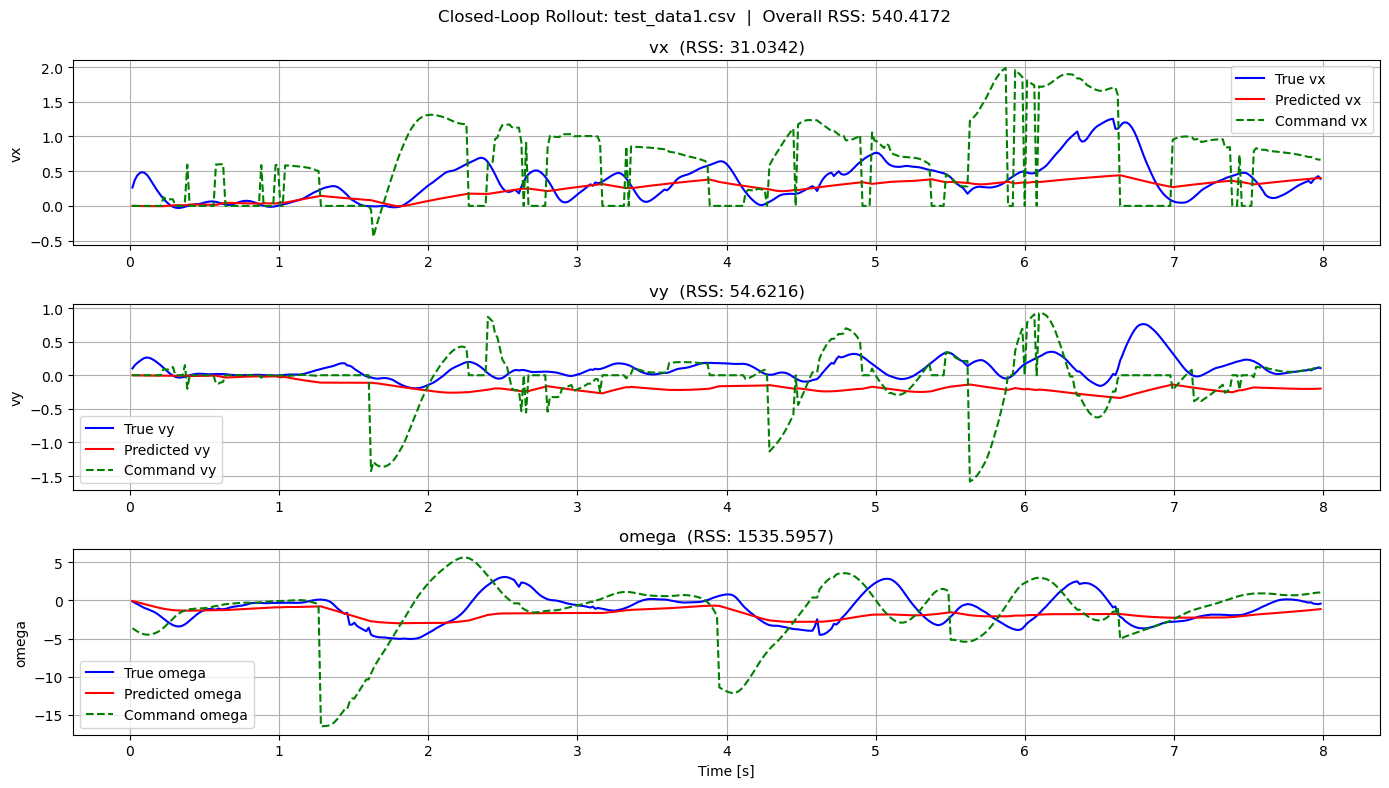

In [118]:
test_model_on_dataset(
    csv_path="test_data1.csv",
    model = OmniSimpleVel(),
    window=500
)

In [119]:
from torch.utils.data import DataLoader, ConcatDataset, random_split
import torch

# Create scaler

dfs = pd.concat([load_and_preprocess_data("test_data1.csv"),
                 load_and_preprocess_data("train_data2.csv") ], ignore_index=True)
scaler = KinematicsScaler()
scaler = scaler.fit(df =dfs)
scaler.save("kinematic_scaler.joblib")

# Combina ambos archivos en un solo dataset
window_size = 30
full_ds = ConcatDataset([
    RobotDataset("test_data1.csv",  window_size, scaler),
    RobotDataset("train_data2.csv", window_size, scaler),
])


val_ratio = 0.2
n_val = int(len(full_ds) * val_ratio)
n_train = len(full_ds) - n_val
train_ds, val_ds = random_split(
    full_ds, [n_train, n_val],
    generator=torch.Generator().manual_seed(42)
)

scaling
scaling


In [120]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = OmniSimpleVel().to(DEVICE)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trainer = Trainer(
    model=model,
    training_loader=train_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=DEVICE,
    validation_loader=val_loader
)

history = trainer.fit(epochs=20, save_path="omni_model.pth")

Epoch 0/20 - train: 2.0970 - val: 0.2042
Mejor modelo guardado (val_loss = 0.2042)
Epoch 1/20 - train: 2.0271 - val: 0.1972
Mejor modelo guardado (val_loss = 0.1972)
Epoch 2/20 - train: 1.9615 - val: 0.1915
Mejor modelo guardado (val_loss = 0.1915)
Epoch 3/20 - train: 1.9154 - val: 0.1877
Mejor modelo guardado (val_loss = 0.1877)
Epoch 4/20 - train: 1.8868 - val: 0.1854
Mejor modelo guardado (val_loss = 0.1854)
Epoch 5/20 - train: 1.8703 - val: 0.1838
Mejor modelo guardado (val_loss = 0.1838)
Epoch 6/20 - train: 1.8584 - val: 0.1826
Mejor modelo guardado (val_loss = 0.1826)
Epoch 7/20 - train: 1.8486 - val: 0.1815
Mejor modelo guardado (val_loss = 0.1815)
Epoch 8/20 - train: 1.8385 - val: 0.1805
Mejor modelo guardado (val_loss = 0.1805)
Epoch 9/20 - train: 1.8274 - val: 0.1793
Mejor modelo guardado (val_loss = 0.1793)
Epoch 10/20 - train: 1.8160 - val: 0.1781
Mejor modelo guardado (val_loss = 0.1781)
Epoch 11/20 - train: 1.8031 - val: 0.1768
Mejor modelo guardado (val_loss = 0.1768)
Ep

In [123]:
# Print OniVelModel parameters
best_physics_model = OmniSimpleVel()
best_physics_model.load_state_dict(torch.load("omni_model.pth"))
for name, param in best_physics_model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

_mass_raw tensor(4.7890)
_inertia_raw tensor(0.3910)
kts tensor([39.2015, 34.6770, 37.8355, 42.8198])
_damping_lin_raw tensor(3.1522)
_damping_rot_raw tensor(-7.1877)
mu_long tensor([2.4211, 2.3937, 1.3698, 3.4453])


C:\Users\Gerso\AppData\Local\Temp\ipykernel_22568\2703628926.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_physics_model.load_state_dict(torch.load("omni_model.pt

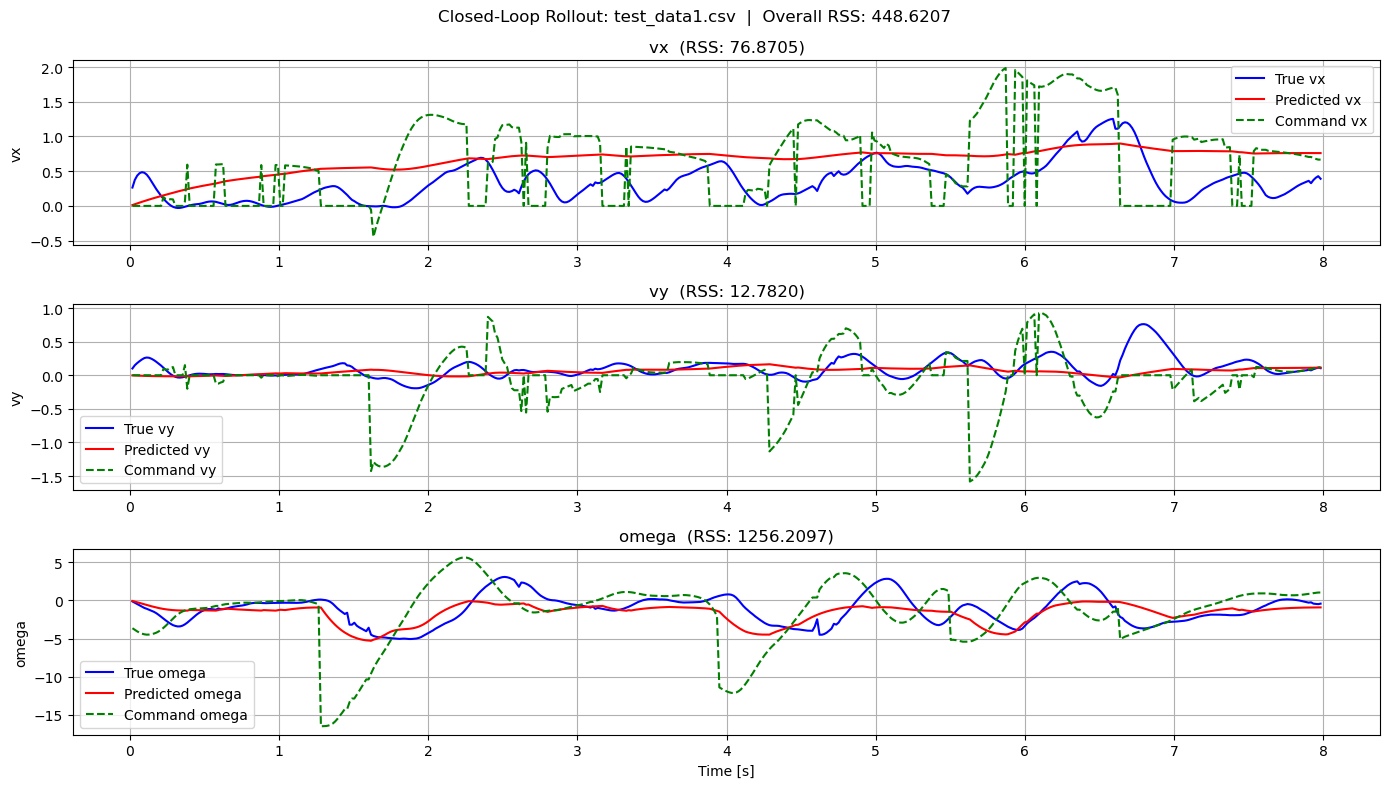

In [129]:
test_model_on_dataset(
    csv_path="test_data1.csv",
    model = best_physics_model,
    window = 500,
    scaler = scaler
)

## Residual Network

In [130]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualDynamicsModel(nn.Module):
    def __init__(self, physical_model):
        super().__init__()
        self.physical_model = physical_model

        # Red neuronal para aprender residuos
        self.residual_net = nn.Sequential(
            nn.Linear(6, 200),  # 6 inputs: [vx, vy, omega, vx_cmd, vy_cmd, omega_cmd]
            nn.Tanh(),
            nn.Linear(200, 128),  # 6 inputs: [vx, vy, omega, vx_cmd, vy_cmd, omega_cmd]
            nn.Tanh(),
            nn.Linear(128, 3)   # 3 outputs: [res_vx, res_vy, res_omega]
        )

        # Ganancia aprendible
        self.residual_gain = nn.Parameter(torch.tensor(0.1))

    def forward(self, x):
        # Predicción del modelo físico
        physical_pred = self.physical_model(x)

        residuals = self.residual_net(x)
        combined = physical_pred + self.residual_gain * residuals

        return combined

In [134]:
# Combina ambos archivos en un solo dataset
window_size = 30
full_ds = ConcatDataset([
    RobotDataset("train_data1.csv",  window_size, scaler),
    RobotDataset("train_data2.csv", window_size, scaler),
])


val_ratio = 0.2
n_val = int(len(full_ds) * val_ratio)
n_train = len(full_ds) - n_val
train_ds, val_ds = random_split(
    full_ds, [n_train, n_val],
    generator=torch.Generator().manual_seed(42)
)

scaling
scaling


In [135]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32)

best_physics_model = OmniSimpleVel()
best_physics_model.load_state_dict(torch.load("omni_model.pth"))
model = ResidualDynamicsModel(best_physics_model)
model.to(DEVICE)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trainer = Trainer(
    model=model,
    training_loader=train_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=DEVICE,
    validation_loader=val_loader
)

history = trainer.fit(epochs=25, save_path = "residual_physics_model.pth" )

C:\Users\Gerso\AppData\Local\Temp\ipykernel_22568\3704950799.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_physics_model.load_state_dict(torch.load("omni_model.pt

Epoch 0/25 - train: 1.0797 - val: 0.0889
Mejor modelo guardado (val_loss = 0.0889)
Epoch 1/25 - train: 0.8103 - val: 0.0690
Mejor modelo guardado (val_loss = 0.0690)
Epoch 2/25 - train: 0.6773 - val: 0.0622
Mejor modelo guardado (val_loss = 0.0622)
Epoch 3/25 - train: 0.6185 - val: 0.0603
Mejor modelo guardado (val_loss = 0.0603)
Epoch 4/25 - train: 0.5719 - val: 0.0537
Mejor modelo guardado (val_loss = 0.0537)
Epoch 5/25 - train: 0.5443 - val: 0.0514
Mejor modelo guardado (val_loss = 0.0514)
Epoch 6/25 - train: 0.5223 - val: 0.0508
Mejor modelo guardado (val_loss = 0.0508)
Epoch 7/25 - train: 0.5026 - val: 0.0471
Mejor modelo guardado (val_loss = 0.0471)
Epoch 8/25 - train: 0.4817 - val: 0.0457
Mejor modelo guardado (val_loss = 0.0457)
Epoch 9/25 - train: 0.4696 - val: 0.0443
Mejor modelo guardado (val_loss = 0.0443)
Epoch 10/25 - train: 0.4566 - val: 0.0444
Epoch 11/25 - train: 0.4486 - val: 0.0435
Mejor modelo guardado (val_loss = 0.0435)
Epoch 12/25 - train: 0.4392 - val: 0.0427
Me

C:\Users\Gerso\AppData\Local\Temp\ipykernel_22568\1332548954.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_residual_model.load_state_dict(torch.load("residual_phy

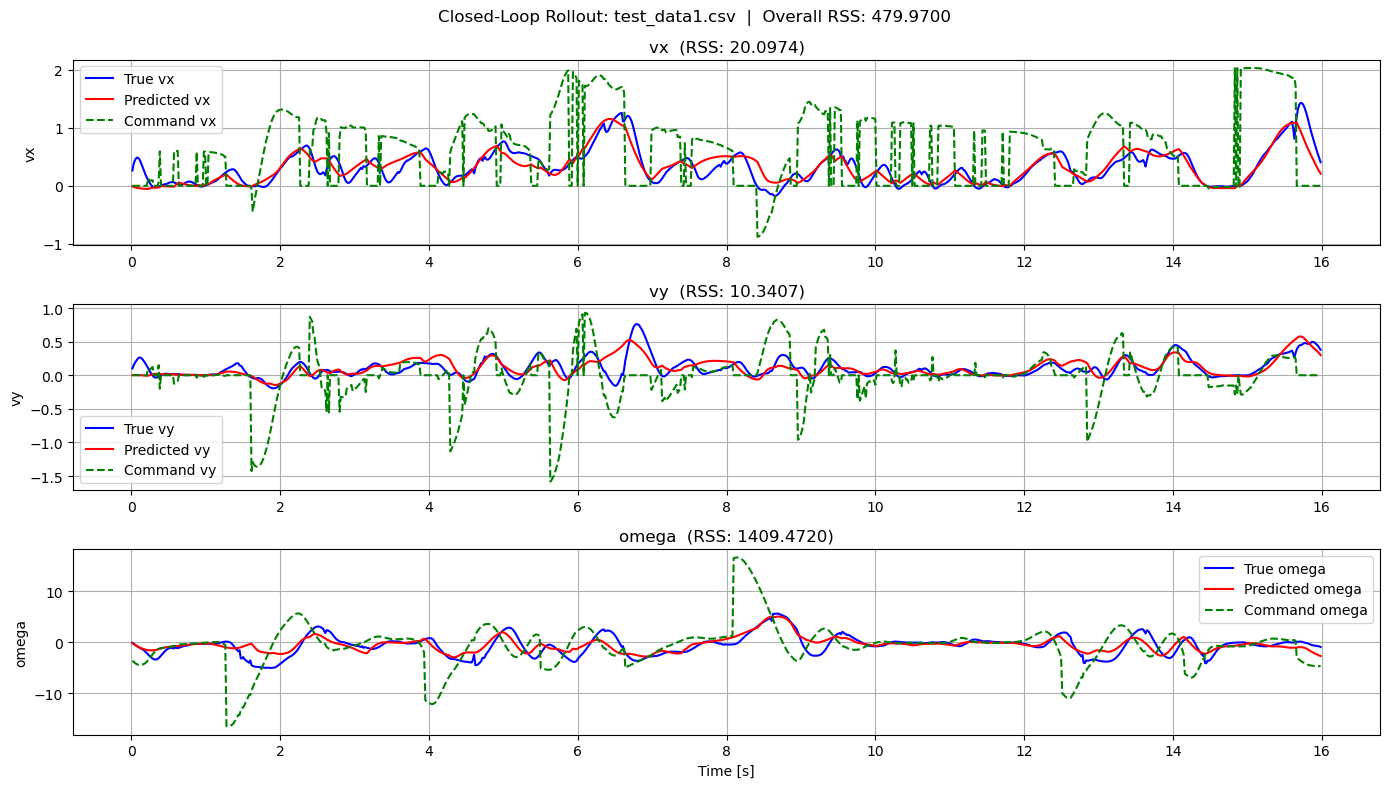

In [136]:
best_residual_model = ResidualDynamicsModel(best_physics_model)
best_residual_model.load_state_dict(torch.load("residual_physics_model.pth"))
test_model_on_dataset(
    csv_path="test_data1.csv",
    model = best_residual_model,
    window = 1000,
    scaler = scaler
)

C:\Users\Gerso\AppData\Local\Temp\ipykernel_22568\1332548954.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_residual_model.load_state_dict(torch.load("residual_phy

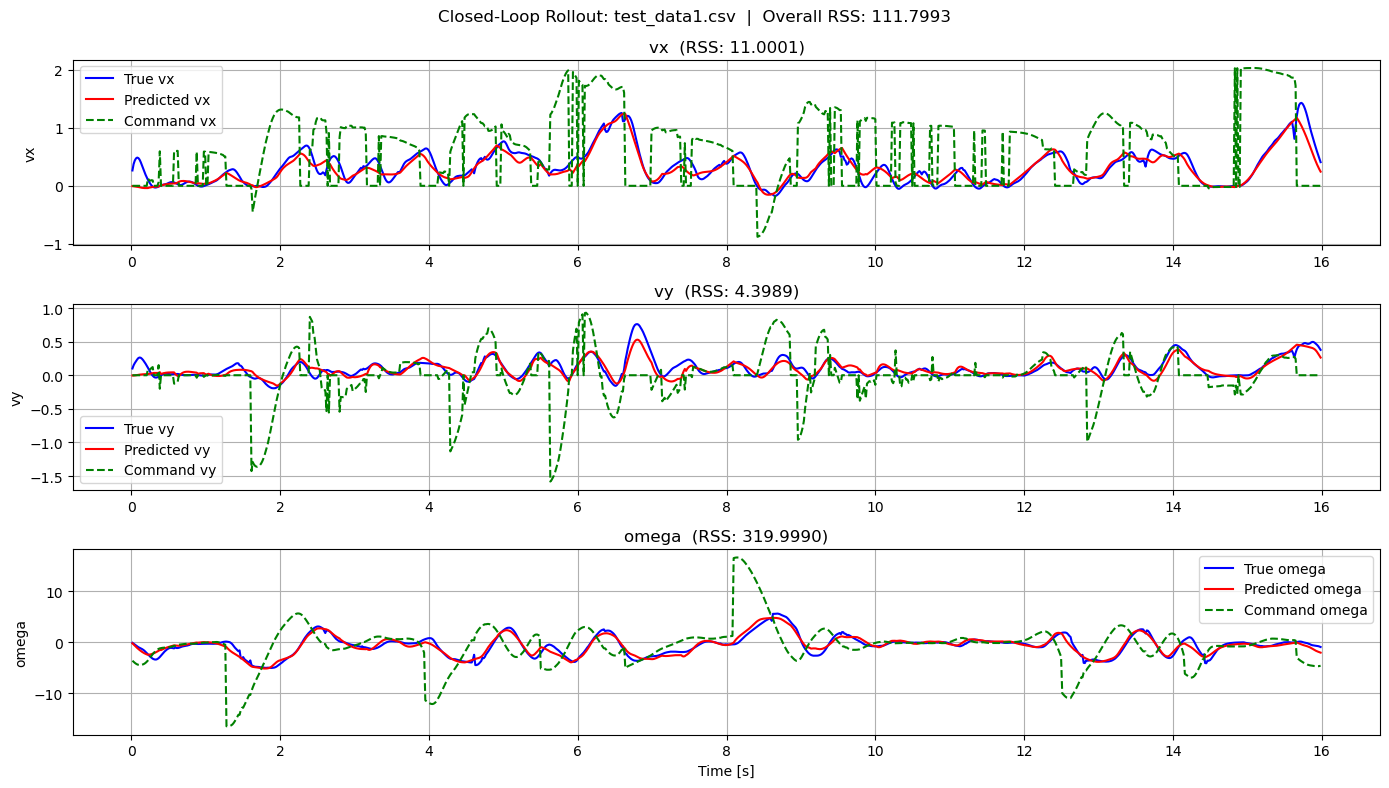

In [132]:
best_residual_model = ResidualDynamicsModel(best_physics_model)
best_residual_model.load_state_dict(torch.load("residual_physics_model.pth"))
test_model_on_dataset(
    csv_path="test_data1.csv",
    model = best_residual_model,
    window = 1000,
    scaler = scaler
)

Hubo una mejora sustancial en el omega al cambiar las ruedas

In [137]:
# Print OniVelModel parameters
for name, param in best_residual_model.physical_model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

_mass_raw tensor(4.5444)
_inertia_raw tensor(1.9174)
kts tensor([39.6999, 34.4517, 36.3756, 42.9468])
_damping_lin_raw tensor(3.2878)
_damping_rot_raw tensor(-7.0368)
mu_long tensor([2.1634, 2.4811, 1.7016, 3.2263])
